<a href="https://colab.research.google.com/github/Sulthon-Araska/Basic-Computational-Astronomy-Astrostatistics/blob/main/Lab_Regresi_Linear_%26_Polinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, pipeline
# polynomial regression --> preprocessing.PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

## for explainer
! pip install lime
from lime import lime_tabular

In [73]:
df   = pd.read_csv('2021PH27N.csv')
cols = ['e', 'inc']
df   = df[cols]
df.head()

,e,inc
0,0.708158,31.8
1,0.803425,31.7
2,0.806995,31.8
3,0.807918,31.7
4,0.804654,31.4


In [74]:
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtype == 'O') | (df[col].nunique() < max_cat):
        return 'cat'
    else:
        return 'num'

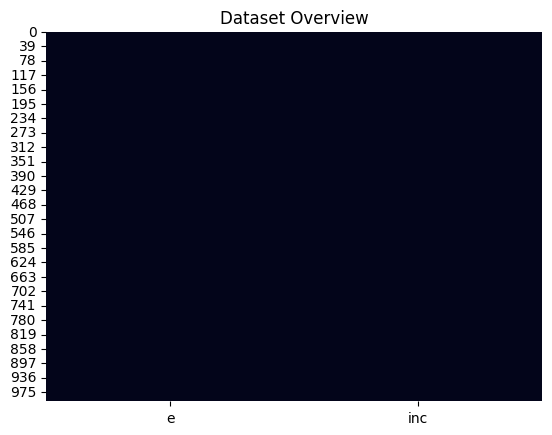

 Categorical   Numeric   nan 


In [75]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
 if v == 'num': heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else         : heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categorical ", "\033[1;30;41m Numeric ", "\033[1;30;47m nan ")

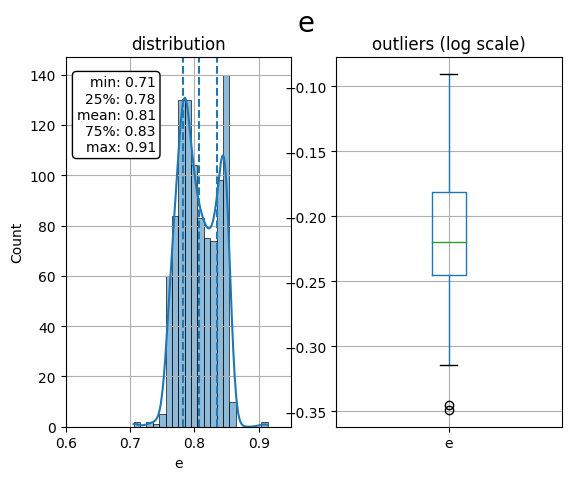

In [76]:
x = 'e'
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
ax[0].set_xlim(0.6, 0.95)
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
sns.histplot(df['e'], kde=True, ax=ax[0])

des = df[x].describe()
ax[0].axvline(des['25%'], ls='--')
ax[0].axvline(des['mean'], ls='--')
ax[0].axvline(des['75%'], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(('min: '+des['min'], '25%: '+des['25%'], 'mean: '+des['mean'], '75%: '+des['75%'], 'max: '+des['max']))
ax[0].text(0.4, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot
ax[1].title.set_text('outliers (log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

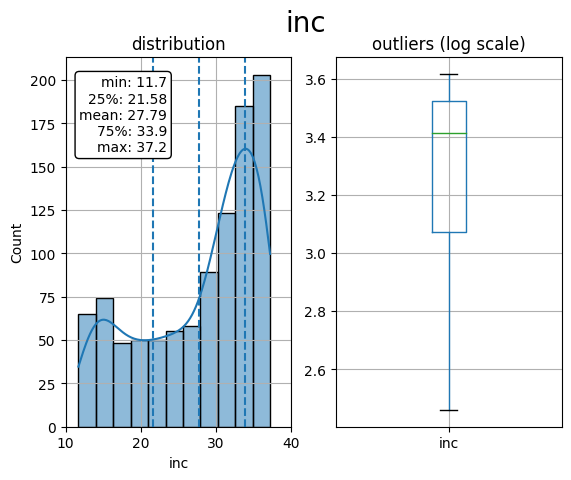

In [77]:
x = 'inc'
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
ax[0].set_xlim(10, 40)
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
sns.histplot(df['inc'], kde=True, ax=ax[0])

des = df[x].describe()
ax[0].axvline(des['25%'], ls='--')
ax[0].axvline(des['mean'], ls='--')
ax[0].axvline(des['75%'], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(('min: '+des['min'], '25%: '+des['25%'], 'mean: '+des['mean'], '75%: '+des['75%'], 'max: '+des['max']))
ax[0].text(0.45, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot
ax[1].title.set_text('outliers (log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

In [78]:
x, y = 'e', 'inc'
df_noNan = df[df[x].notnull()]
coeff, p = scipy.stats.pearsonr(df_noNan[x], df_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = 'significant' if p < 0.05 else 'non-significant'
print(f'Pearson correlation: {coeff:+.3f} {conclusion} (p-value: {str(p)})')

Pearson correlation: -0.931 significant (p-value: 0.0)


In [79]:
## split data
df_train, df_test = model_selection.train_test_split(df,test_size=0.3)
## print info
print('e_train shape :', df_train.drop('inc',axis=1).shape, '| e_test shape :', df_test.drop('inc',axis=1).shape)
print('inc_train mean:', round(np.mean(df_train['inc']),2), '| inc_test mean:', round(np.mean(df_test['inc']),2))
print(df_train.shape[1], 'features:', df_train.drop('inc',axis=1).columns.to_list())

e_train shape : (700, 1) | e_test shape : (300, 1)
inc_train mean: 27.67 | inc_test mean: 28.07
2 features: ['e']


Text(0.5, 1.0, 'pearson correlation')

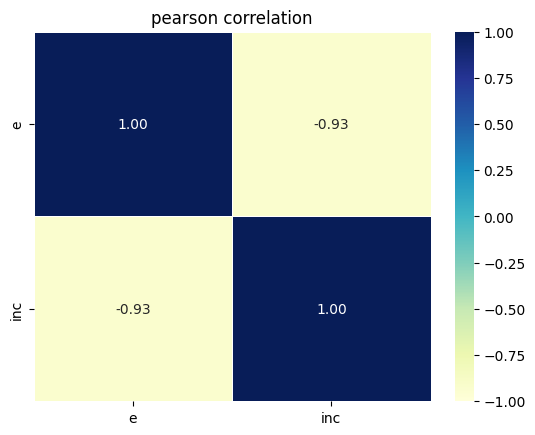

In [80]:
corr_matrix = df_train.corr(method='pearson')
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title('pearson correlation')

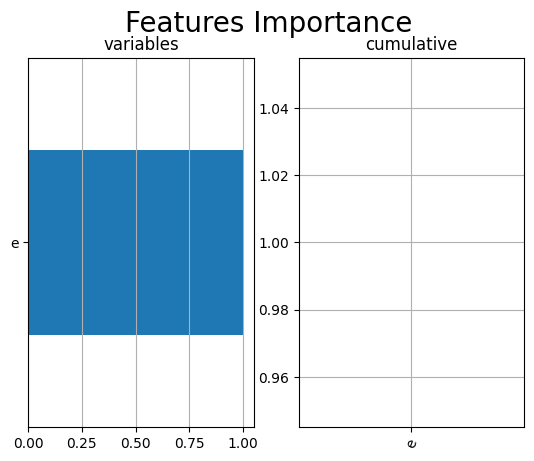

In [81]:
X = df_train.drop("inc", axis=1).values
y = df_train["inc"].values
feature_names = df_train.drop("inc", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas df
df_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
df_importances["cumsum"] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")

## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

# Training

In [82]:
X_names = ['e']
X_train = df_train[X_names].values
y_train = df_train["inc"].values
X_test = df_test[X_names].values
y_test = df_test["inc"].values

In [83]:
min(X)[0]

0.705527

In [84]:
max(X)[0]

0.913533

Fold 1, R2 = 0.82, intercept = +228.78, coeff = [-249.16320479]
Fold 2, R2 = 0.88, intercept = +224.52, coeff = [-244.25617135]
Fold 3, R2 = 0.91, intercept = +227.11, coeff = [-247.20277433]
Fold 4, R2 = 0.91, intercept = +225.26, coeff = [-244.86354603]
Fold 5, R2 = 0.78, intercept = +226.79, coeff = [-246.78820911]
R2 average = 0.86


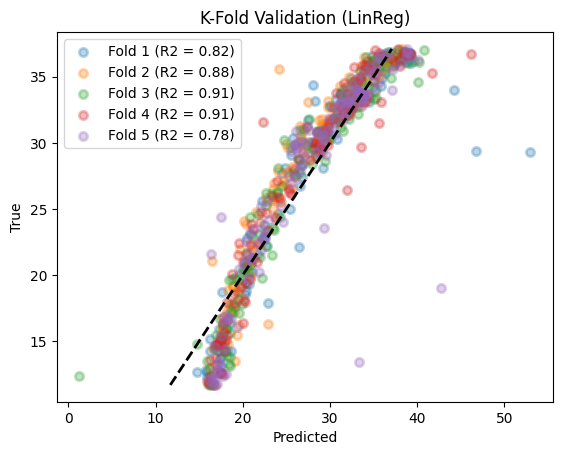

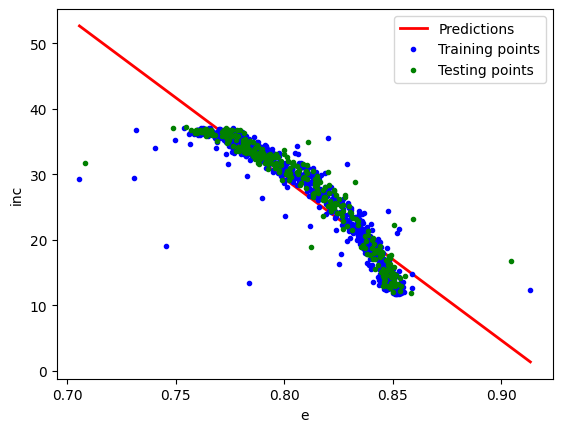

In [85]:
## call model
model = linear_model.LinearRegression()

## K fold validation
scores = []
mean   = 0.
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    mean += score
    plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    print(f'Fold {i:d}, R2 = {score:.2f}, intercept = {model.intercept_:+.2f}, coeff = {model.coef_}')
    i = i+1
mean = mean/len(scores)
print(f'R2 average = {mean:.2f}')
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation (LinReg)')
plt.legend()
plt.show()

X_new = np.linspace(min(X)[0], max(X)[0], 200).reshape(200, 1)
X_new_lin = X_new
y_new = model.predict(X_new_lin)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_train, y_train, "b.",label='Training points')
plt.plot(X_test, y_test, "g.",label='Testing points')
plt.xlabel("e")
plt.ylabel("inc")
plt.legend()
plt.show()

In [86]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

In [87]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.87
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.09
Mean Absolute Error (Σ|y-pred|/n): 2
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 3
Max Error: -20


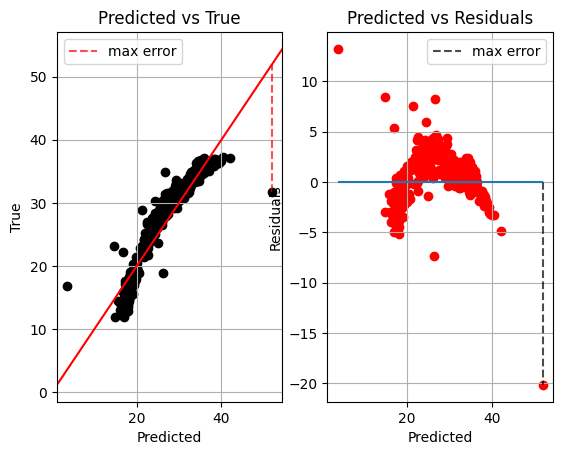

In [88]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

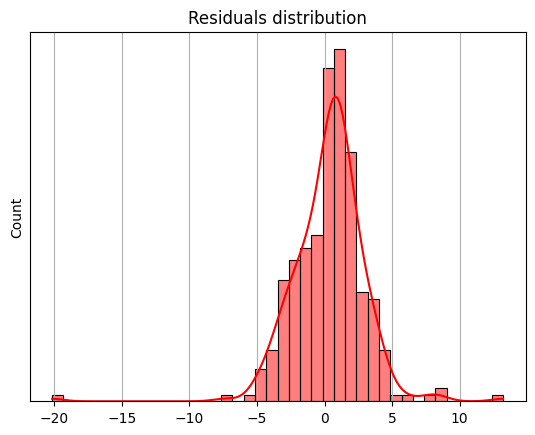

In [89]:
fig, ax = plt.subplots()
sns.histplot(residuals, color='red', kde=True, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [90]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 32 --> Pred: 31


Fold 1, R2 = 0.900, intercept = -995.70, coeff = [    0.          2783.62935738 -1875.58034018]
Fold 2, R2 = 0.900, intercept = -995.70, coeff = [    0.          2783.62935738 -1875.58034018]
Fold 3, R2 = 0.900, intercept = -995.70, coeff = [    0.          2783.62935738 -1875.58034018]
Fold 4, R2 = 0.900, intercept = -995.70, coeff = [    0.          2783.62935738 -1875.58034018]
Fold 5, R2 = 0.900, intercept = -995.70, coeff = [    0.          2783.62935738 -1875.58034018]
R2 average = 0.900


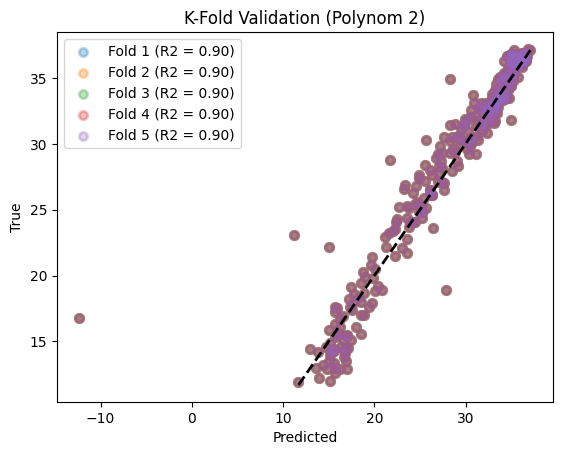

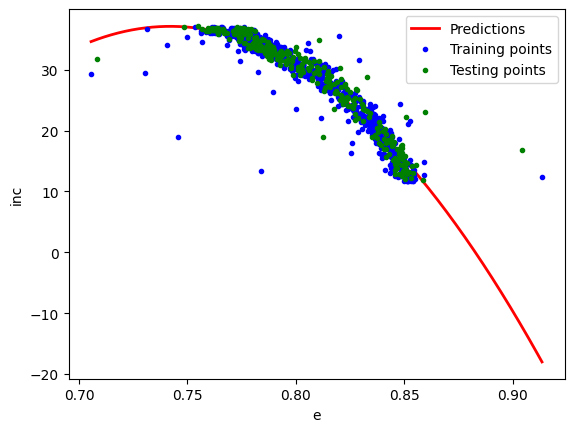

In [91]:
## call model
model = PolynomialFeatures(degree=2, include_bias=True)

## K fold validation
scores = []
mean   = 0.
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_trans = model.fit_transform(X_train)
    X_test_trans  = model.transform(X_test)
    true = y_train[test]

    #include bias parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train_trans, y_train)
    y_pred = lr.predict(X_test_trans)

    score = metrics.r2_score(y_test, y_pred)
    scores.append(score)

    mean += score

    plt.scatter(y_pred, y_test, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    print(f'Fold {i:d}, R2 = {score:.3f}, intercept = {lr.intercept_:+.2f}, coeff = {lr.coef_}')
    i = i+1

mean = mean/len(scores)
print(f'R2 average = {mean:.3f}')
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation (Polynom 2)')
plt.legend()
plt.show()

X_new = np.linspace(min(X)[0], max(X)[0], 200).reshape(200, 1)
X_new_poly = model.transform(X_new)
y_new = lr.predict(X_new_poly)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_train, y_train, "b.",label='Training points')
plt.plot(X_test, y_test, "g.",label='Testing points')
plt.xlabel("e")
plt.ylabel("inc")
plt.legend()
plt.show()

Fold 1, R2 = 0.927, intercept = -10206.03, coeff = [     0.          37158.26702279 -44598.39167781  17682.33189822]
Fold 2, R2 = 0.927, intercept = -10206.03, coeff = [     0.          37158.26702279 -44598.39167781  17682.33189822]
Fold 3, R2 = 0.927, intercept = -10206.03, coeff = [     0.          37158.26702279 -44598.39167781  17682.33189822]
Fold 4, R2 = 0.927, intercept = -10206.03, coeff = [     0.          37158.26702279 -44598.39167781  17682.33189822]
Fold 5, R2 = 0.927, intercept = -10206.03, coeff = [     0.          37158.26702279 -44598.39167781  17682.33189822]
R2 average = 0.927


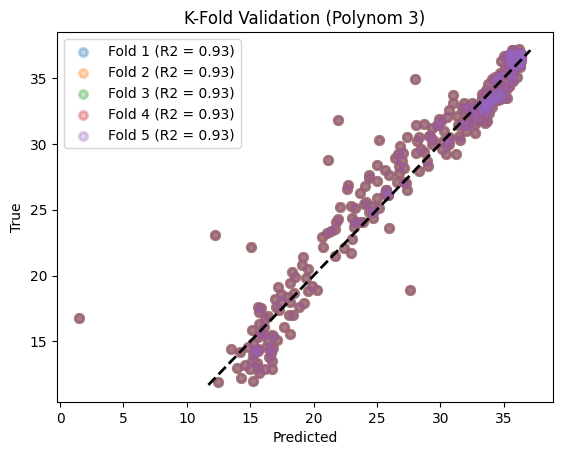

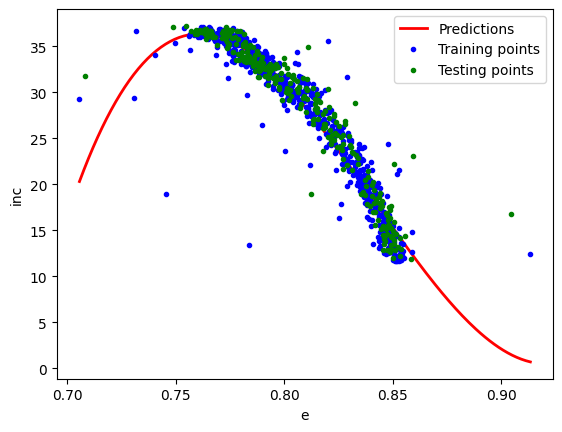

In [92]:
## call model
model = PolynomialFeatures(degree=3, include_bias=True)

## K fold validation
scores = []
mean   = 0.
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_trans = model.fit_transform(X_train)
    X_test_trans  = model.transform(X_test)
    true = y_train[test]

    #include bias parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train_trans, y_train)
    y_pred = lr.predict(X_test_trans)

    score = metrics.r2_score(y_test, y_pred)
    scores.append(score)

    mean += score

    plt.scatter(y_pred, y_test, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    print(f'Fold {i:d}, R2 = {score:.3f}, intercept = {lr.intercept_:+.2f}, coeff = {lr.coef_}')
    i = i+1

mean = mean/len(scores)
print(f'R2 average = {mean:.3f}')
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation (Polynom 3)')
plt.legend()
plt.show()

X_new = np.linspace(min(X)[0], max(X)[0], 200).reshape(200, 1)
X_new_poly = model.transform(X_new)
y_new = lr.predict(X_new_poly)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_train, y_train, "b.",label='Training points')
plt.plot(X_test, y_test, "g.",label='Testing points')
plt.xlabel("e")
plt.ylabel("inc")
plt.legend()
plt.show()

Fold 1, R2 = 0.942, intercept = +63465.89, coeff = [      0.         -328260.20253584  634080.99286007 -541704.57441574
  172643.15907854]
Fold 2, R2 = 0.942, intercept = +63465.89, coeff = [      0.         -328260.20253584  634080.99286007 -541704.57441574
  172643.15907854]
Fold 3, R2 = 0.942, intercept = +63465.89, coeff = [      0.         -328260.20253584  634080.99286007 -541704.57441574
  172643.15907854]
Fold 4, R2 = 0.942, intercept = +63465.89, coeff = [      0.         -328260.20253584  634080.99286007 -541704.57441574
  172643.15907854]
Fold 5, R2 = 0.942, intercept = +63465.89, coeff = [      0.         -328260.20253584  634080.99286007 -541704.57441574
  172643.15907854]
R2 average = 0.942


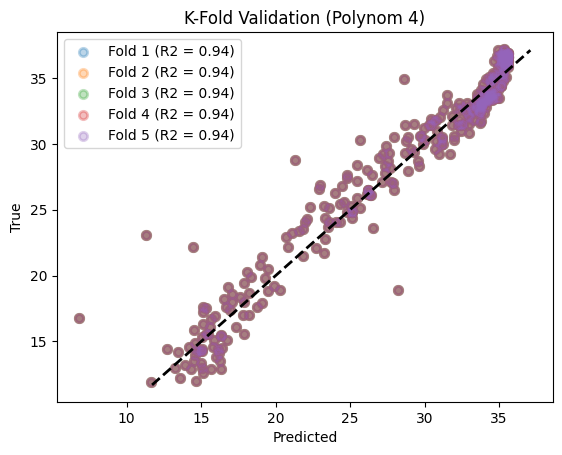

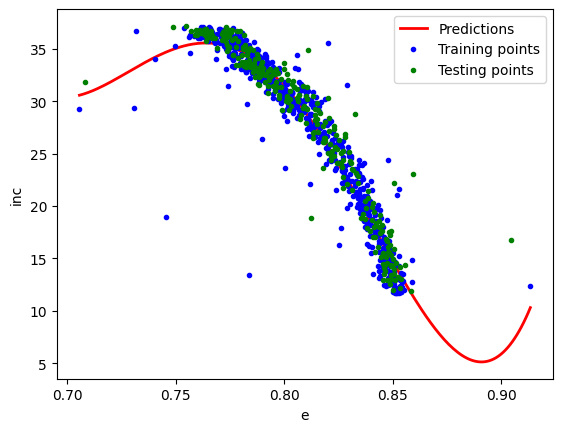

In [93]:
## call model
model = PolynomialFeatures(degree=4, include_bias=True)

## K fold validation
scores = []
mean   = 0.
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_trans = model.fit_transform(X_train)
    X_test_trans  = model.transform(X_test)
    true = y_train[test]

    #include bias parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train_trans, y_train)
    y_pred = lr.predict(X_test_trans)

    score = metrics.r2_score(y_test, y_pred)
    scores.append(score)

    mean += score

    plt.scatter(y_pred, y_test, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    print(f'Fold {i:d}, R2 = {score:.3f}, intercept = {lr.intercept_:+.2f}, coeff = {lr.coef_}')
    i = i+1

mean = mean/len(scores)
print(f'R2 average = {mean:.3f}')
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation (Polynom 4)')
plt.legend()
plt.show()

X_new = np.linspace(min(X)[0], max(X)[0], 200).reshape(200, 1)
X_new_poly = model.transform(X_new)
y_new = lr.predict(X_new_poly)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_train, y_train, "b.",label='Training points')
plt.plot(X_test, y_test, "g.",label='Testing points')
plt.xlabel("e")
plt.ylabel("inc")
plt.legend()
plt.show()

Fold 1, R2 = 0.942, intercept = -605544.48, coeff = [       0.          3835671.08639094 -9715494.60651118 12299317.85087011
 -7780404.87941148  1967036.83216573]
Fold 2, R2 = 0.942, intercept = -605544.48, coeff = [       0.          3835671.08639094 -9715494.60651118 12299317.85087011
 -7780404.87941148  1967036.83216573]
Fold 3, R2 = 0.942, intercept = -605544.48, coeff = [       0.          3835671.08639094 -9715494.60651118 12299317.85087011
 -7780404.87941148  1967036.83216573]
Fold 4, R2 = 0.942, intercept = -605544.48, coeff = [       0.          3835671.08639094 -9715494.60651118 12299317.85087011
 -7780404.87941148  1967036.83216573]
Fold 5, R2 = 0.942, intercept = -605544.48, coeff = [       0.          3835671.08639094 -9715494.60651118 12299317.85087011
 -7780404.87941148  1967036.83216573]
R2 average = 0.942


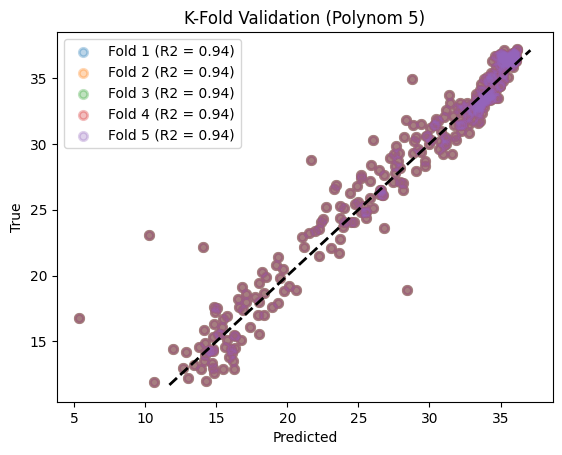

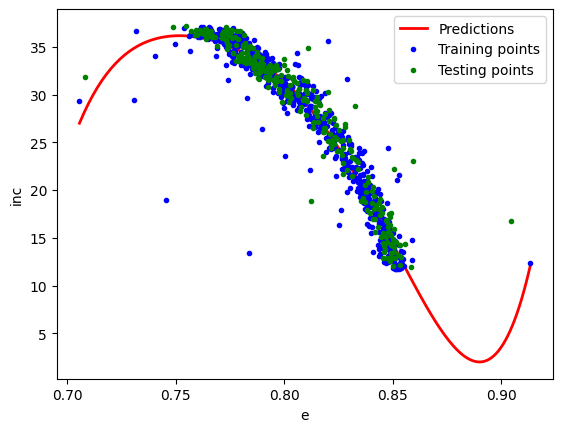

In [94]:
## call model
model = PolynomialFeatures(degree=5, include_bias=True)

## K fold validation
scores = []
mean   = 0.
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_trans = model.fit_transform(X_train)
    X_test_trans  = model.transform(X_test)
    true = y_train[test]

    #include bias parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train_trans, y_train)
    y_pred = lr.predict(X_test_trans)

    score = metrics.r2_score(y_test, y_pred)
    scores.append(score)

    mean += score

    plt.scatter(y_pred, y_test, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    print(f'Fold {i:d}, R2 = {score:.3f}, intercept = {lr.intercept_:+.2f}, coeff = {lr.coef_}')
    i = i+1

mean = mean/len(scores)
print(f'R2 average = {mean:.3f}')
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation (Polynom 5)')
plt.legend()
plt.show()

X_new = np.linspace(min(X)[0], max(X)[0], 200).reshape(200, 1)
X_new_poly = model.transform(X_new)
y_new = lr.predict(X_new_poly)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_train, y_train, "b.",label='Training points')
plt.plot(X_test, y_test, "g.",label='Testing points')
plt.xlabel("e")
plt.ylabel("inc")
plt.legend()
plt.show()

In [95]:
## train
lr.fit(X_train_trans, y_train)

## test
predicted = lr.predict(X_test_trans)

In [96]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.94
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.06
Mean Absolute Error (Σ|y-pred|/n): 1
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 2
Max Error: 13


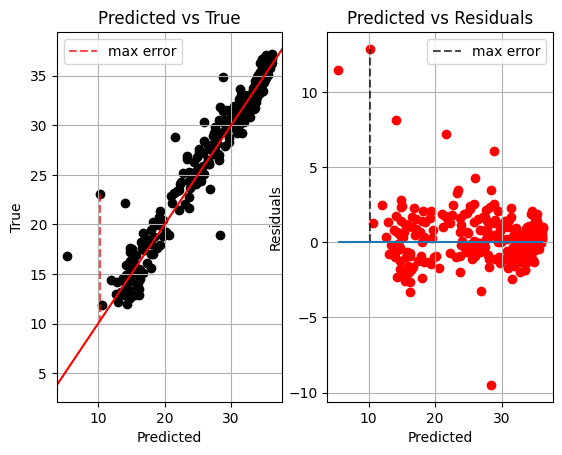

In [97]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

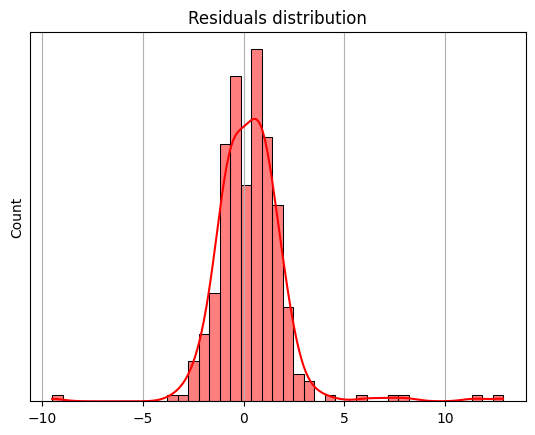

In [98]:
fig, ax = plt.subplots()
sns.histplot(residuals, color='red', kde=True, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [99]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 32 --> Pred: 33
